## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import utils
import matplotlib.pyplot as plt
from lane_finder import LaneFinder
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
images = glob.glob('./camera_cal/calibration*.jpg')
mtx, dist = utils.calibrate_camera(images)

## Calibrate the camera and undistort the image

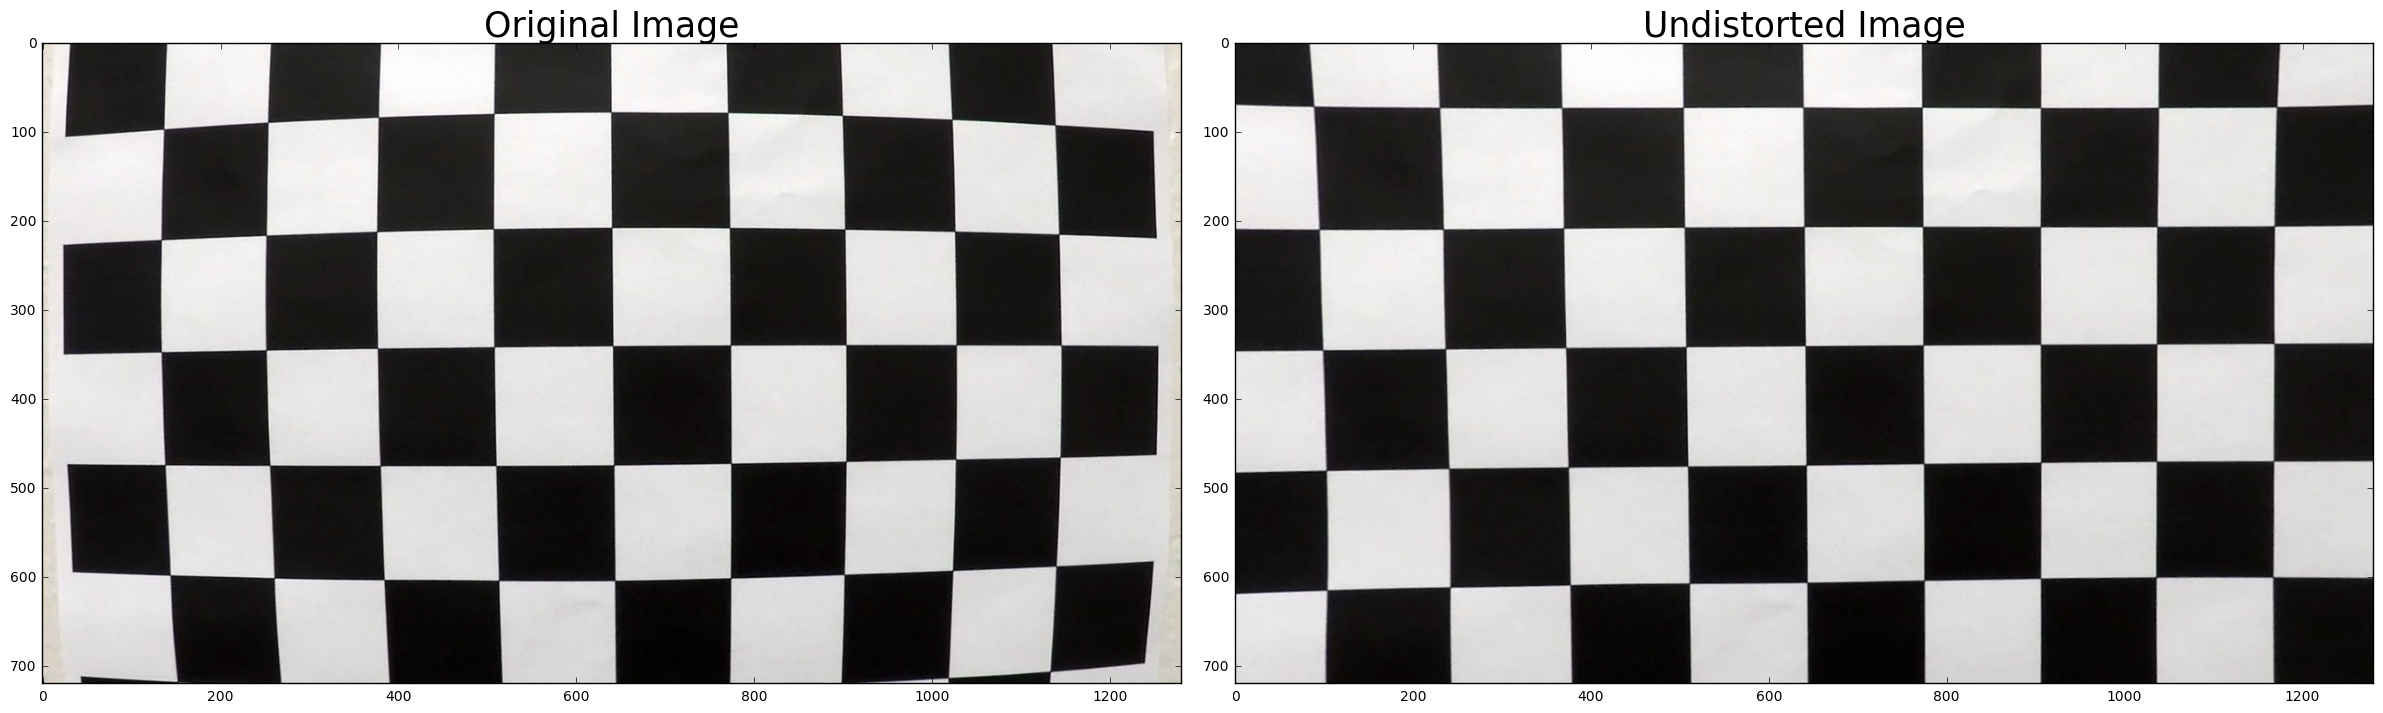

In [3]:
#generate the image correction matrix
img = utils.load_image('./camera_cal/calibration1.jpg')

dst = utils.undistort(img, mtx, dist)

f, (axis1, axis2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
axis1.imshow(img)
axis1.set_title('Original Image', fontsize=25)
axis2.imshow(dst)
axis2.set_title('Undistorted Image', fontsize=25)

In [4]:
def draw_region_of_interest(img, region, color=[255,0,0]):
    img = np.copy(img).astype(np.uint8)
    left_top = tuple(region[0])
    left_bottom = tuple(region[1])
    right_bottom = tuple(region[2])
    right_top = tuple(region[3])

    cv2.line(img, left_bottom, left_top, color, 2)
    cv2.line(img, left_top, right_top, color, 2)
    cv2.line(img, right_top, right_bottom, color, 2)
    cv2.line(img, right_bottom, left_bottom, color, 2)
    return img

In [21]:
def get_transformation_source(h, w, left=0.44, right=0.56, top=0.655, bottom=1):
    top_left = [w * left, h * top, ]
    top_right = [w * right, h * top]
    bottom_left = [w * 0.16, h * bottom]
    bottom_right = [w * 0.86, h * bottom]
    return np.array([top_left, bottom_left, bottom_right, top_right], np.float32)


def get_transformation_destination(h, w):
    top_left = [w * 0.25, 0]
    top_right = [w * 0.75, 0]
    bottom_left = [w * 0.25, h]
    bottom_right = [w * 0.75, h]
    return np.array([top_left, bottom_left, bottom_right, top_right], np.float32)


def convert_to_birds_eye_view(img):
    h, w = img.shape[:2]

    src = get_transformation_source(h, w)
    dest = get_transformation_destination(h, w)

    img = utils.perspective_transform(img, src, dest)

    return img, src, dest

Test the perespective transformation on a straight road segment

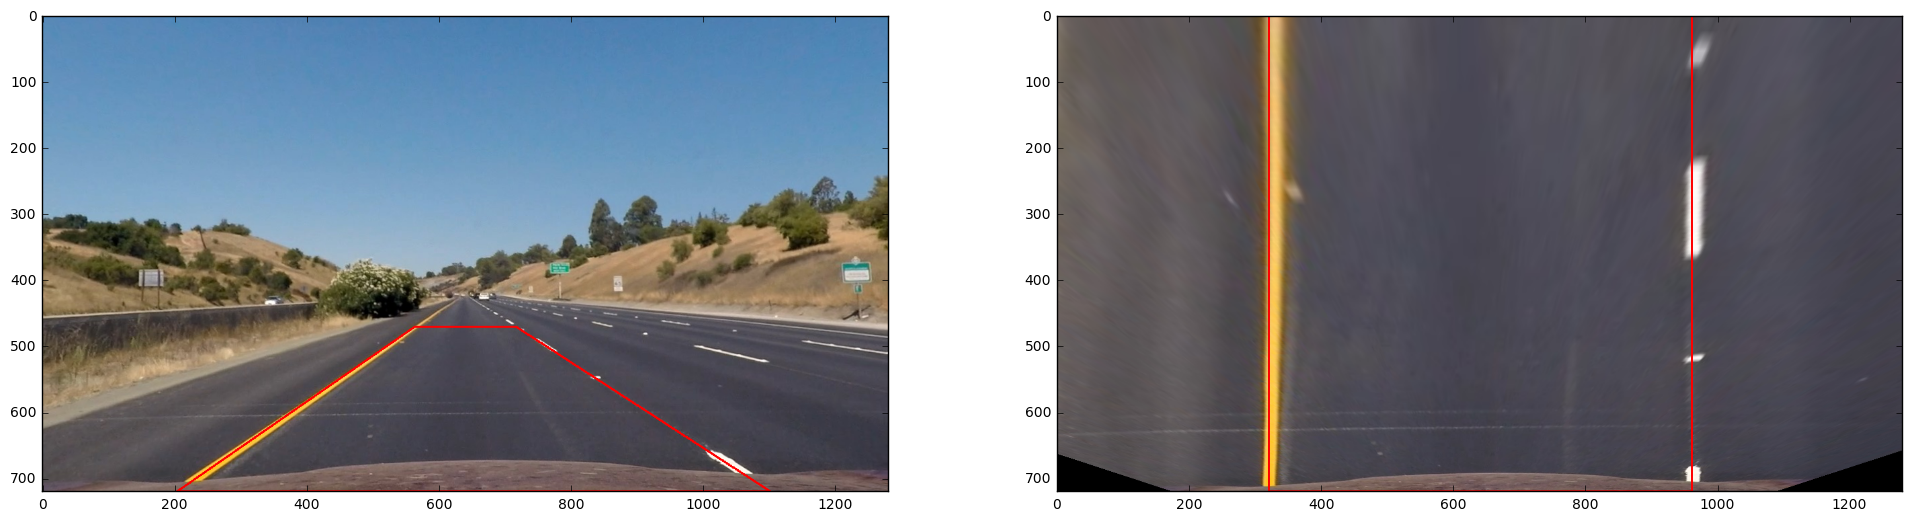

In [22]:
img = utils.load_image('./test_images/straight_lines1.jpg')
img = utils.undistort(img, mtx, dist)

img_top, src, dest = convert_to_birds_eye_view(img)
img = draw_region_of_interest(img, src)
img_top = draw_region_of_interest(img_top, dest)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax2.imshow(img_top)

In [38]:
def detect_white_line(image):
    l = np.array([100, 100, 200])
    u = np.array([255, 255, 255])
    detected = cv2.inRange(image, l, u)
    binary = np.zeros(image.shape[:2])
    binary[(detected > 0)] = 1

    return binary

def detect_yellow_line(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    l = np.array([ 20, 100, 100])
    u = np.array([ 40, 255, 255])
    detected = cv2.inRange(image, l, u)
    binary = np.zeros(image.shape[:2])
    binary[(detected > 0)] = 1

    return binary

def create_binary(img, mtx, dist):
    warped = utils.undistort(img, mtx, dist)
    
    #convert to birds eye view
    warped, src, dst = convert_to_birds_eye_view(warped)
    
    # Threshold x gradient
    x_sobel = utils.abs_sobel_threshold(warped,'x', 5, thresh=(20, 170))

    yellow = detect_yellow_line(warped)
    white = detect_white_line(warped)

    # Threshold color channel
    
    combined_binary = np.zeros_like(x_sobel)
    combined_binary[(white==1) | (yellow == 1)] = 1

    return combined_binary

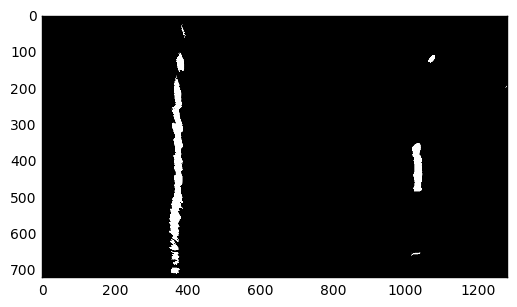

In [39]:
img = utils.load_image('./test_images/test4.jpg')
#img = cv2.flip(img, 1)

res = create_binary(img, mtx, dist)
plt.imshow(res, cmap='gray')
#f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
#ax1.imshow(img)
#ax2.imshow(res, cmap='gray')

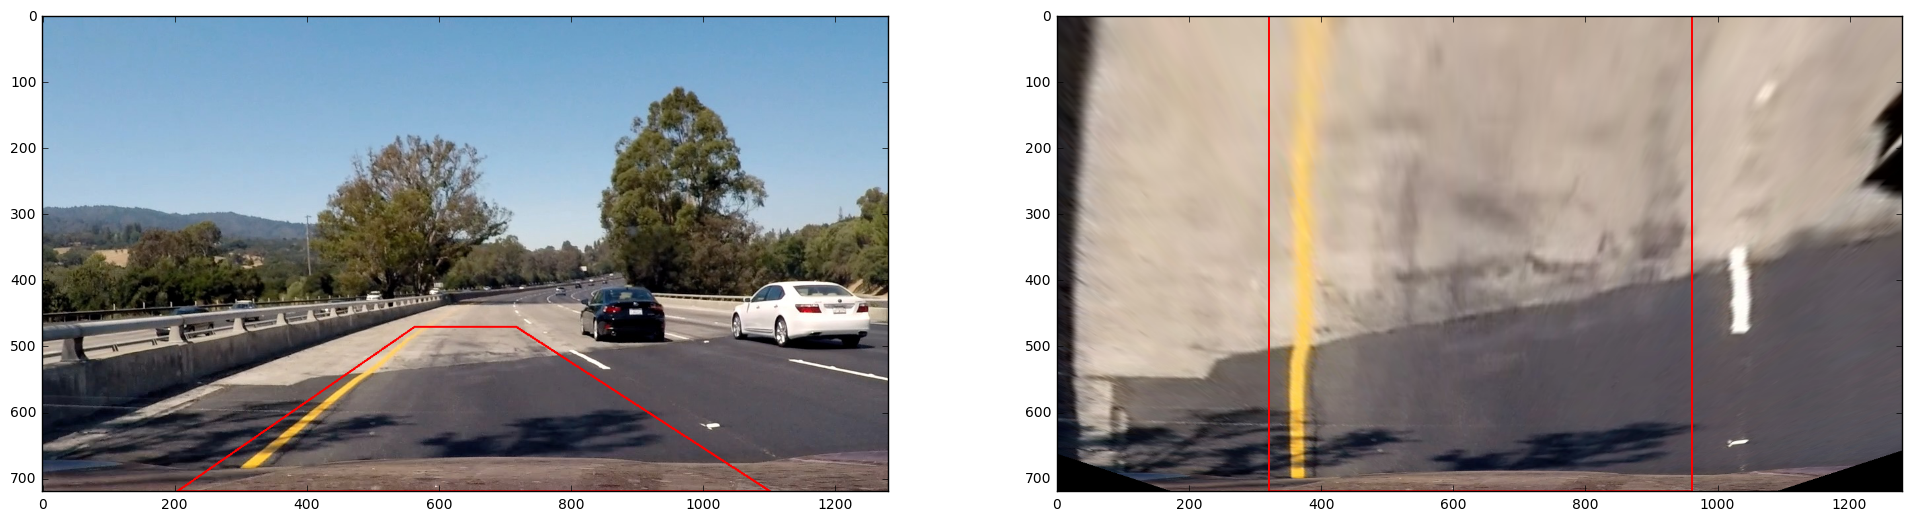

In [25]:
img_top, src, dest = convert_to_birds_eye_view(img)
img_area = draw_region_of_interest(img, src)
img_top = draw_region_of_interest(img_top, dest)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img_area)
ax2.imshow(img_top)

In [26]:
def get_line_centers(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base

def get_lane(image, center, num_windows=9, width=50, minpix=100):
    h = image.shape[0]
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    lane = []
    window_height = h//num_windows
    current = center
    
    for window in range(num_windows):
        lo = h - (window+1)*window_height
        hi = h - window * window_height
        left = current - width
        right = current + width
        
        good_idx = ((nonzeroy >= lo) & (nonzeroy < hi) & 
                  (nonzerox >= left) & (nonzerox < right)).nonzero()[0]
        lane.append(good_idx)
        if len(good_idx) > minpix:
            current = np.int(np.mean(nonzerox[good_idx]))
        
    lane = np.concatenate(lane)
    return  nonzeroy[lane], nonzerox[lane]

def fit_line(fit, y):
    return fit[0]*y**2 + fit[1]*y + fit[2]

def get_line_coef(x, y):
    return np.polyfit(y, x, 2)

(720, 0)

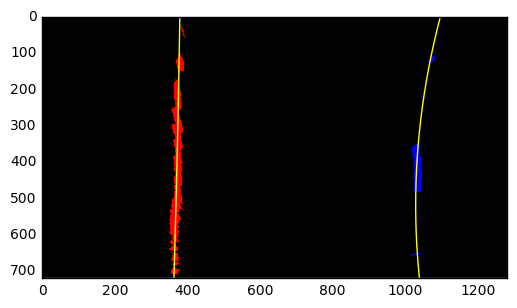

In [27]:
# Create an output image to draw on and  visualize the result

leftx_base, rightx_base = get_line_centers(res)

# Create empty lists to receive left and right lane pixel indices
lefty, leftx = get_lane(res, leftx_base)
righty, rightx = get_lane(res, rightx_base)

left_fit = get_line_coef(leftx, lefty)
right_fit = get_line_coef(rightx, righty)

fity = np.linspace(0, res.shape[0]-1, res.shape[0] )
fit_leftx = fit_line(left_fit, fity)
fit_rightx = fit_line(right_fit, fity)

out_img = np.zeros_like(img)
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [28]:
def project_on_image(img, fit_leftx, fit_rightx, fity,  src, dest):
    color_warp = np.zeros_like(img).astype(np.uint8)

    Minv = cv2.getPerspectiveTransform(dest, src)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

def project_on_be(img, fit_leftx, fit_rightx, fity,  src, dest):
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, color_warp, 0.3, 0)
    return result

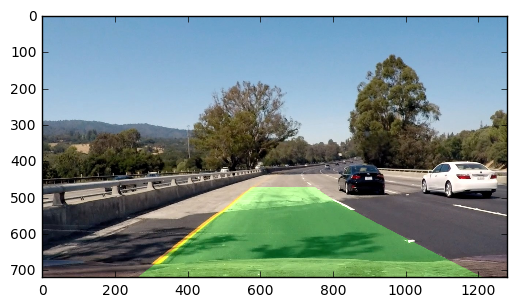

In [29]:
result = project_on_image(img, fit_leftx, fit_rightx, fity, src, dest)
plt.imshow(result)

In [30]:
def find_lane(image, fit, width=100):
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] - width)) & 
                  (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] + width))) 
    
    x = nonzerox[left_lane_inds]
    y = nonzeroy[left_lane_inds] 
    return x,y

In [31]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
leftx, lefty = find_lane(res, left_fit)
rightx, righty = find_lane(res, right_fit)

# Fit a second order polynomial to each
left_fit = get_line_coef(leftx, lefty)
right_fit = get_line_coef(rightx, righty)

# Generate x and y values for plotting
fity = np.linspace(0, res.shape[0]-1, res.shape[0] )
fit_leftx = fit_line(left_fit, fity)
fit_rightx = fit_line(right_fit, fity)

In [32]:
def draw_search_area(out_img, fitx, fity, margin=100):
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    window_img = np.zeros_like(out_img)
    line_window1 = np.array([np.transpose(np.vstack([fitx-margin, fity]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx+margin, fity])))])
    line_pts = np.hstack((line_window1, line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result

(720, 0)

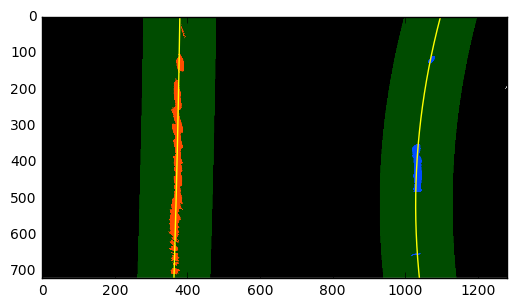

In [33]:
out_img = np.dstack((res, res, res))*255

# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

result = draw_search_area(out_img, fit_leftx, fity)
result = draw_search_area(result, fit_rightx, fity)

plt.imshow(result)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

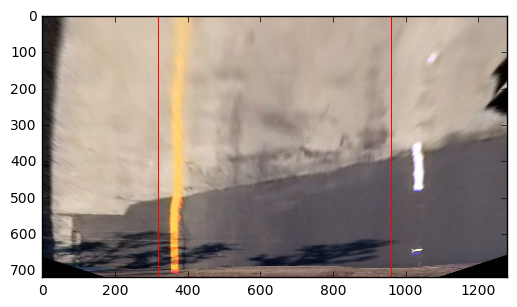

In [34]:
result = cv2.addWeighted(img_top, 1, out_img, 1.0, 1)
plt.imshow(result)

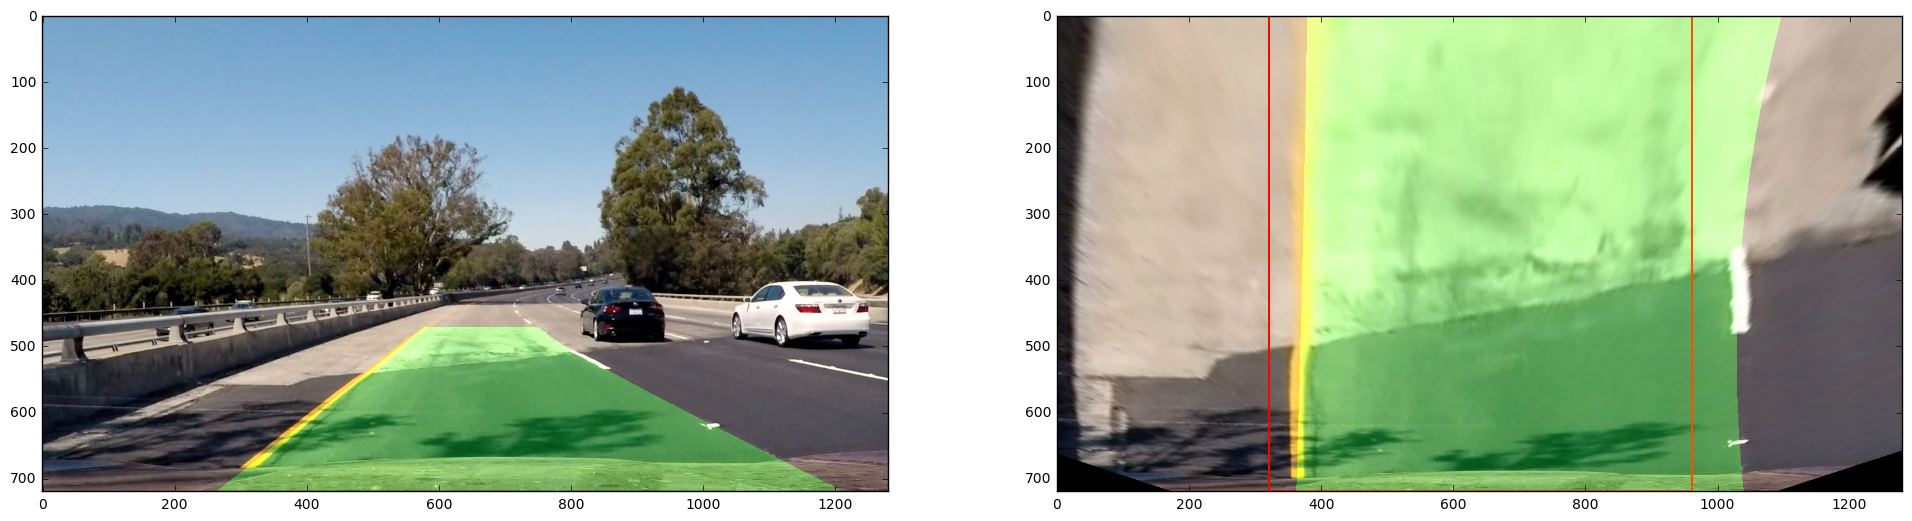

In [35]:
# Create an image to draw the lines on
result = project_on_image(img, fit_leftx, fit_rightx, fity, src, dest)
be_p = project_on_be(img_top, fit_leftx, fit_rightx, fity, src, dest)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
ax1.imshow(result)
ax2.imshow(be_p)

In [36]:
def get_curvature(fit, fity):
    y_eval = np.max(fity)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(fity*ym_per_pix, fit*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    return left_curverad

def get_deviation_from_center(img, left, right):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    middle = img.shape[1] / 2
    dev = (left + right >> 1 ) - middle
    return dev * xm_per_pix

16096.0298775 644.700401279


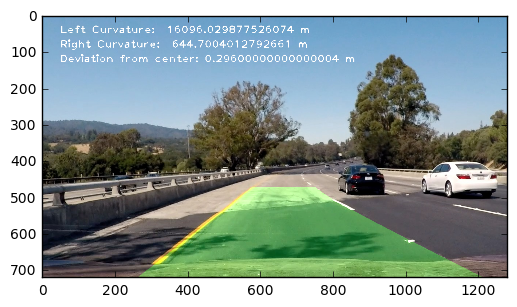

In [37]:
left_curverad = get_curvature(fit_leftx, fity)
right_curverad = get_curvature(fit_rightx, fity)
print(left_curverad, right_curverad)

res = np.copy(result)
l_text = "Left Curvature:  {} m".format(left_curverad)
r_text = "Right Curvature:  {} m".format(right_curverad)
dev_text    = "Deviation from center: {} m".format(get_deviation_from_center(res, leftx_base, rightx_base))
cv2.putText(res, l_text, (50,50), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)
cv2.putText(res, r_text, (50,90), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)
cv2.putText(res, dev_text, (50,130), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)
plt.imshow(res)